In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Convolution2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.preprocessing.sequence import skipgrams

C:\Users\liu0563\Miniconda3\envs\nlp\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
# Upload Data 

data = pd.read_csv("../wyns/data/tweet_global_warming.csv", encoding="latin")
print("Full dataset: {}".format(data.shape[0]))
data['existence'].fillna(value='Ambiguous', inplace = True) #replace NA's in existence with "ambiguous"
data['existence'].replace(('Y', 'N'), ('Yes', 'No'), inplace=True) #rename so encoder doesnt get confused
data = data.dropna() #now drop NA values
print("dataset without NaN: {}".format(data.shape[0]))

data['existence'][10:20]

Full dataset: 6090
dataset without NaN: 6087


10          Yes
11          Yes
12          Yes
13          Yes
14    Ambiguous
15          Yes
16          Yes
17           No
18          Yes
19          Yes
Name: existence, dtype: object

In [4]:
def read_data(data_file):
    for i, line in enumerate (data_file): 
        # do some pre-processing and return a list of words for each review text
        yield gensim.utils.simple_preprocess (line)

tweet_vocab = list(read_data(data['tweet']))

In [14]:
X = data.iloc[:,0] #store tweets in X 

labels = data.iloc[:,1]
confidence_interval = data.iloc[:,2]

# encode class as integers 
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels) 

# convert integers to one hot encoded
Y_one_hot = np_utils.to_categorical(encoded_Y)


# multiply one-hot by confidence intervals
Y=[]
for i, row in enumerate(confidence_interval):
    Y.append(row*Y_one_hot[i])
Y[0:5]
Y = np.array(Y)

In [15]:
Y[10:20]

array([[0.    , 0.    , 0.9073],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 0.5488],
       [0.    , 0.    , 0.8823],
       [1.    , 0.    , 0.    ],
       [0.    , 0.    , 0.75  ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.6648, 0.    ],
       [0.    , 0.    , 1.    ],
       [0.    , 0.    , 0.5194]], dtype=float32)

In [16]:
test_split = 0.8
train_size = int(len(X)*test_split)
test_size = len(X) - train_size
vector_size = 300
window_size = 10
max_tweet_length=28

indexes = set(np.random.choice(len(tweet_vocab), train_size + test_size, replace=False))

X_train = np.zeros((train_size, max_tweet_length, vector_size))
Y_train = np.zeros((train_size, 3), dtype=np.float32)
X_test = np.zeros((test_size, max_tweet_length, vector_size))
Y_test = np.zeros((test_size, 3), dtype=np.float32)

In [17]:
X.shape[0]

6087

In [18]:
list(inds[:10])

NameError: name 'inds' is not defined

In [20]:
# create a single array of processed data
XX = np.zeros((len(X),max_tweet_length, vector_size))
for i in range(XX.shape[0]):
    for j, twit in enumerate(tweet_vocab[i]):
        if twit not in X_vecs:
            continue
        XX[i,j,:] = X_vecs[twit]
# print(XX[:-10,:,:])
        
# print(XX.shape)




inds = np.arange(XX.shape[0])
np.random.shuffle(inds)
# print(inds)
train = list(inds[:X.shape[0]*3//4])
test = list(inds[X.shape[0]*3//4:])
X_train = XX[train]
X_train = X_train.reshape(*X_train.shape,1)
X_test = XX[test]
X_test = X_test.reshape(*X_test.shape,1)
Y_train = Y[train]
# Y_train = Y_train.reshape(*Y_train.shape,1)
Y_test = Y[test]
# Y_test = Y_test.reshape(*Y_test.shape,1)

In [10]:
google = gensim.models.KeyedVectors.load_word2vec_format('../wyns/data/GoogleNews-vectors-negative300.bin.gz',binary=True)
vocab = google.vocab.keys()
total_vocab = len(vocab)
print ("Set includes", total_vocab, "words")
X_vecs = google.wv
del google

Set includes 3000000 words


C:\Users\liu0563\Miniconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [61]:
np.floor(np.random.rand(3)*100)

array([78., 12., 23.])

In [74]:
X_resample, Y_resample = bootstrap(X_train,Y_train,10)

### A short video on how bagging works https://www.youtube.com/watch?v=2Mg8QD0F1dQ 

In [21]:
def bootstrap(X,Y, n=None):
#Bootstrap function
    if n == None:
        n = len(X)   
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    Y_resample = Y[resample_i]
    return X_resample, Y_resample

In [22]:
def bagging(n_sample,n_bag):
#Perform bagging procedure. Bootstrap and obtain an ensamble of models
    X_resample, Y_resample = bootstrap(X_train,Y_train, n_sample)
    bagModels = {}
    for i in range(n_bag):
        print("Model fitting on the {}th bootstrapped set".format(i+1))
        model = model_fit(X_resample,Y_resample)
        name = "model%s" % (i+1)
        bagModels[name] = model
    return bagModels

In [23]:
def model_fit(X_train,Y_train):
    filters = 32 #filter = 1 x KERNEL 
    inpurt_shape = (X_train.shape[1:])
    # create the model 
    model = Sequential()

    model.add(Convolution2D(16, kernel_size=3, activation='elu', padding='same',
                 input_shape=inpurt_shape))
    model.add(MaxPooling2D(pool_size=5))
    model.add(Convolution2D(filters=filters, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=5))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='linear')) #change from logistic 
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mse']) 

    # Fit the model
    model.fit(X_train, 
              Y_train, 
              epochs=20, 
              batch_size=128,
              verbose=1)
    return model

In [24]:
def predict(bagModels):
# Model prediction for each bagged model before averaging 
    prediction = {}
    for i in bagModels:
        prediction[i] = bagModels[i].predict(X_test)
    return prediction

In [25]:
def conversion(prediction):
# Convert confidence values into prediction
    pred_list=[]
    for i in range(len(prediction)):
        index = np.argmax(prediction[i])
        if index == 0:
            pred = 'Ambiguous'
        elif index == 1:
            pred = 'No'
        else:
            pred = 'Yes'
        pred_list.append(pred)
    return pred_list

In [26]:
def baggedAccuracy(prediction,Y_test):
#Bagged accuracy calculation based on average confidences 
    sum_pred = 0
    for i in prediction:
        sum_pred += prediction[i]
    bagged_prediction = sum_pred/30
    bagged_list = conversion(bagged_prediction)
    Ytest_list = conversion(Y_test)
    correct_pred = sum(1 for i in range(len(bagged_list)) if bagged_list[i] == Ytest_list[i])
    baggedAccuracy = correct_pred/len(bagged_list) * 100
    return baggedAccuracy

First, we need to perform the splitting procedure as we did in the CNN notebook to get train and test sets <br/>
Now lets perform bagging of an ensamble of 50 models with each model containing 3800 bootstrapped samples from X_train

In [340]:
bagModel = bagging(3800,50)

Model fitting on the 1th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 201s 53ms/step - loss: 0.1491 - acc: 0.4853 - mean_squared_error: 0.1491
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1416 - acc: 0.5047 - mean_squared_error: 0.1416
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1409 - acc: 0.5047 - mean_squared_error: 0.1409
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1396 - acc: 0.5053 - mean_squared_error: 0.1396
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1378 - acc: 0.5074 - mean_squared_error: 0.1378
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1356 - acc: 0.5129 - mean_squared_error: 0.1356
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1311 - acc: 0.5321 - mean_squared_error: 0.1311
Epoch 8/20
3800/3800 [==============================] - 7s 2

Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1386 - acc: 0.5066 - mean_squared_error: 0.1386
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1355 - acc: 0.5142 - mean_squared_error: 0.1355
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1298 - acc: 0.5405 - mean_squared_error: 0.1298
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1243 - acc: 0.5697 - mean_squared_error: 0.1243
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1126 - acc: 0.6229 - mean_squared_error: 0.1126
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1012 - acc: 0.6782 - mean_squared_error: 0.1012
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0984 - acc: 0.6905 - mean_squared_error: 0.0984
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0901 - acc: 0.7282 - mean_squared_erro

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1179 - acc: 0.6082 - mean_squared_error: 0.1179
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1087 - acc: 0.6539 - mean_squared_error: 0.1087
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1009 - acc: 0.6858 - mean_squared_error: 0.1009
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0927 - acc: 0.7221 - mean_squared_error: 0.0927
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0846 - acc: 0.7461 - mean_squared_error: 0.0846
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0766 - acc: 0.7789 - mean_squared_error: 0.0766
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0699 - acc: 0.7987 - mean_squared_error: 0.0699
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0666 - acc: 0.8171 - mean_squared_error: 0.0

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0700 - acc: 0.7963 - mean_squared_error: 0.0700
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0672 - acc: 0.8034 - mean_squared_error: 0.0672
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0629 - acc: 0.8197 - mean_squared_error: 0.0629
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0591 - acc: 0.8389 - mean_squared_error: 0.0591
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0563 - acc: 0.8466 - mean_squared_error: 0.0563
Model fitting on the 17th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 12s 3ms/step - loss: 0.1499 - acc: 0.4895 - mean_squared_error: 0.1499
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1422 - acc: 0.5045 - mean_squared_error: 0.1422
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step 

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1417 - acc: 0.5047 - mean_squared_error: 0.1417
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1409 - acc: 0.5055 - mean_squared_error: 0.1409
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1397 - acc: 0.5058 - mean_squared_error: 0.1397
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1382 - acc: 0.5068 - mean_squared_error: 0.1382
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1348 - acc: 0.5137 - mean_squared_error: 0.1348
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1266 - acc: 0.5516 - mean_squared_error: 0.1266
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1179 - acc: 0.5887 - mean_squared_error: 0.1179
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1073 - acc: 0.6445 - mean_squared_error: 0.1073
Epo

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1255 - acc: 0.5492 - mean_squared_error: 0.1255
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1160 - acc: 0.6089 - mean_squared_error: 0.1160
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1051 - acc: 0.6479 - mean_squared_error: 0.1051
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0977 - acc: 0.6824 - mean_squared_error: 0.0977
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0930 - acc: 0.7000 - mean_squared_error: 0.0930
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0853 - acc: 0.7303 - mean_squared_error: 0.0853
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0819 - acc: 0.7458 - mean_squared_error: 0.0819
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0778 - acc: 0.7655 - mean_squared_error: 0.07

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0740 - acc: 0.7855 - mean_squared_error: 0.0740
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0700 - acc: 0.7958 - mean_squared_error: 0.0700
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0638 - acc: 0.8171 - mean_squared_error: 0.0638
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0582 - acc: 0.8442 - mean_squared_error: 0.0582
Epoch 18/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0543 - acc: 0.8484 - mean_squared_error: 0.0543
Epoch 19/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0514 - acc: 0.8574 - mean_squared_error: 0.0514
Epoch 20/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0482 - acc: 0.8721 - mean_squared_error: 0.0482
Model fitting on the 36th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 15s 4ms/ste

3800/3800 [==============================] - 7s 2ms/step - loss: 0.0526 - acc: 0.8579 - mean_squared_error: 0.0526
Model fitting on the 42th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 14s 4ms/step - loss: 0.1530 - acc: 0.4792 - mean_squared_error: 0.1530
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1426 - acc: 0.5055 - mean_squared_error: 0.1426
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1403 - acc: 0.5061 - mean_squared_error: 0.1403
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1395 - acc: 0.5047 - mean_squared_error: 0.1395
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1391 - acc: 0.5053 - mean_squared_error: 0.1391
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1366 - acc: 0.5074 - mean_squared_error: 0.1366
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - lo

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1394 - acc: 0.5066 - mean_squared_error: 0.1394
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1393 - acc: 0.5068 - mean_squared_error: 0.1393
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1367 - acc: 0.5071 - mean_squared_error: 0.1367
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1335 - acc: 0.5132 - mean_squared_error: 0.1335
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1297 - acc: 0.5408 - mean_squared_error: 0.1297
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1237 - acc: 0.5676 - mean_squared_error: 0.1237
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1169 - acc: 0.5974 - mean_squared_error: 0.1169
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1067 - acc: 0.6563 - mean_squared_error: 0.1067
Ep

### Bagging different numbers of models in an ensamble to test accuracy change

In [431]:
bagModel2 = bagging(3800,10)

Model fitting on the 1th bootstrapped set
(28, 300, 1)
Epoch 1/20
3800/3800 [==============================] - 19s 5ms/step - loss: 0.1500 - acc: 0.4782 - mean_squared_error: 0.1500
Epoch 2/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1414 - acc: 0.4976 - mean_squared_error: 0.1414
Epoch 3/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1398 - acc: 0.4984 - mean_squared_error: 0.1398
Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1378 - acc: 0.4989 - mean_squared_error: 0.1378
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1353 - acc: 0.5034 - mean_squared_error: 0.1353
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1308 - acc: 0.5176 - mean_squared_error: 0.1308
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1233 - acc: 0.5561 - mean_squared_error: 0.1233
Epoch 8/20
3800/3800 [==============================] - 7s 2ms

Epoch 4/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1388 - acc: 0.4997 - mean_squared_error: 0.1388
Epoch 5/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1378 - acc: 0.4987 - mean_squared_error: 0.1378
Epoch 6/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1356 - acc: 0.5013 - mean_squared_error: 0.1356
Epoch 7/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1320 - acc: 0.5176 - mean_squared_error: 0.1320
Epoch 8/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1281 - acc: 0.5289 - mean_squared_error: 0.1281
Epoch 9/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1176 - acc: 0.5897 - mean_squared_error: 0.1176
Epoch 10/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1059 - acc: 0.6516 - mean_squared_error: 0.1059
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0971 - acc: 0.6900 - mean_squared_erro

3800/3800 [==============================] - 7s 2ms/step - loss: 0.1207 - acc: 0.5737 - mean_squared_error: 0.1207
Epoch 11/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1124 - acc: 0.6145 - mean_squared_error: 0.1124
Epoch 12/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.1045 - acc: 0.6561 - mean_squared_error: 0.1045
Epoch 13/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0990 - acc: 0.6726 - mean_squared_error: 0.0990
Epoch 14/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0863 - acc: 0.7297 - mean_squared_error: 0.0863
Epoch 15/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0811 - acc: 0.7487 - mean_squared_error: 0.0811
Epoch 16/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0748 - acc: 0.7716 - mean_squared_error: 0.0748
Epoch 17/20
3800/3800 [==============================] - 7s 2ms/step - loss: 0.0718 - acc: 0.7866 - mean_squared_error: 0.0

In [465]:
bagged_predict.keys()

dict_keys(['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'model14', 'model15', 'model16', 'model17', 'model18', 'model19', 'model20', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26', 'model27', 'model28', 'model29', 'model30', 'model31', 'model32', 'model33', 'model34', 'model35', 'model36', 'model37', 'model38', 'model39', 'model40', 'model41', 'model42', 'model43', 'model44', 'model45', 'model46', 'model47', 'model48', 'model49', 'model50'])

In [411]:
bagged_predict = predict(bagModel)

In [467]:
Accuracy= baggedAccuracy(bagged_predict,Y_test)
print("Bagged Accuracy(50 models): %.2f%% "%Accuracy)

Bagged Accuracy(50 models): 62.48% 


### Improved accuracy! Variance reduction helps!

In [435]:
bagModel2.keys()

dict_keys(['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10'])

In [447]:
bag_pred2 = predict(bagModel2)

In [466]:
Accuracy2= baggedAccuracy(bag_pred2,Y_test)
print("Bagged Accuracy(10 models): %.2f%% "%Accuracy2)

Bagged Accuracy(10 models): 62.29% 


### The results for 10-model and 50-model ensamble are only slightly different

In [54]:
n_sample = int(len(X_train)*0.6)
n_sample

2739

In [28]:
model_num_list = [10,20,30,40,50]

In [33]:
def accuracy_bag(n_sample,model_num_list):
    model_bags = []
    accuracy_bags = []
    for i in model_num_list:
        print('Bagging {} models'.format(i))
        bagmodel = bagging(n_sample,i)
        bag_pred = predict(bagmodel)
        Accuracy = baggedAccuracy(bag_pred,Y_test)
        accuracy_bags.append(Accuracy)
    return accuracy_bags

I tried to get the accuracy of an ensamble from 1 to 50 models but my machine broke down overnight.. <br>I guess this is where GCP becomes handy. Next up: perform bagging for LSTM model. <br> You can see from the accuracy plot: 3/5 of the bagging accuracy is better than a single model accuracy without bagging(Single model accuracy 60.97 in this case). <br> Another point is as you randomly select observations for your training set and your bag size (the previous bagging accuracy was obtained by performing with another randomly selected training set and a bag size of 3800), the resulting accuracy can be different by several percentage. <br> I think bagging would help our model accuracy but not in a tremendous way. The results proved that the variance of our model was not signicant comparing to bias. Tune the hyperparameters!

In [52]:
accuracybags

[61.62943495400789,
 60.2496714848883,
 63.929040735873855,
 63.074901445466494,
 60.775295663600524]

In [40]:
accuracybags_array = np.asarray(accuracybags)

In [38]:
from matplotlib import pyplot as plt

Text(0,0.5,'Bagging accuracy')

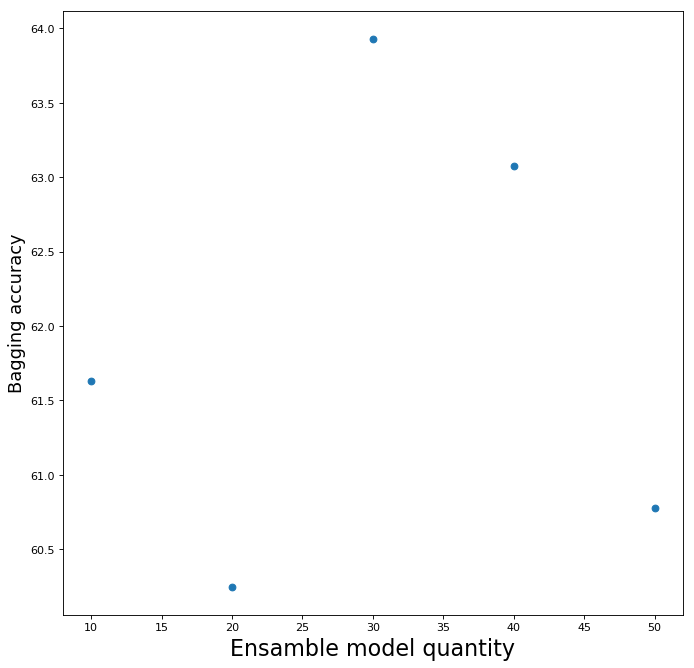

In [53]:
plt.figure(figsize=(10,10),dpi=80)
plt.scatter(model_num_list,accuracybags)
plt.xlabel('Ensamble model quantity',fontsize=20)
plt.ylabel('Bagging accuracy',fontsize=16)

In [34]:
accuracybags = accuracy_bag(n_sample,model_num_list)

Bagging 10 models
Model fitting on the 1th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1560 - acc: 0.4819 - mean_squared_error: 0.1560
Epoch 2/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1444 - acc: 0.4900 - mean_squared_error: 0.1444
Epoch 3/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1425 - acc: 0.4984 - mean_squared_error: 0.1425
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1406 - acc: 0.4969 - mean_squared_error: 0.1406
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1405 - acc: 0.5016 - mean_squared_error: 0.1405
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1388 - acc: 0.4947 - mean_squared_error: 0.1388
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1365 - acc: 0.5016 - mean_squared_error: 0.1365
Epoch 8/20
2739/2739 [==============================] - 4s

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1416 - acc: 0.4980 - mean_squared_error: 0.1416
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1418 - acc: 0.4973 - mean_squared_error: 0.1418
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1404 - acc: 0.4976 - mean_squared_error: 0.1404
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1380 - acc: 0.4991 - mean_squared_error: 0.1380
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1378 - acc: 0.4991 - mean_squared_error: 0.1378
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1348 - acc: 0.5002 - mean_squared_error: 0.1348
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1295 - acc: 0.5265 - mean_squared_error: 0.1295
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1208 - acc: 0.5772 - mean_squared_error: 0.1208
Ep

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1430 - acc: 0.4958 - mean_squared_error: 0.1430
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1417 - acc: 0.4965 - mean_squared_error: 0.1417
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1396 - acc: 0.4984 - mean_squared_error: 0.1396
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1382 - acc: 0.4969 - mean_squared_error: 0.1382: 0s - loss: 0.1378 - acc: 0.4959 - mean_squared_err
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1365 - acc: 0.5002 - mean_squared_error: 0.1365
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1330 - acc: 0.5053 - mean_squared_error: 0.1330
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1278 - acc: 0.5312 - mean_squared_error: 0.1278
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss:

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1409 - acc: 0.4973 - mean_squared_error: 0.1409
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1402 - acc: 0.4980 - mean_squared_error: 0.1402
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1391 - acc: 0.4984 - mean_squared_error: 0.1391
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1381 - acc: 0.4995 - mean_squared_error: 0.1381: 0s - loss: 0.1383 - acc: 0.5011 - mean_squared_error: 0.13
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1349 - acc: 0.5002 - mean_squared_error: 0.1349
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1332 - acc: 0.5184 - mean_squared_error: 0.1332
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1281 - acc: 0.5345 - mean_squared_error: 0.1281
Epoch 12/20
2739/2739 [==============================] - 4s 2ms/ste

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1392 - acc: 0.5009 - mean_squared_error: 0.1392: 1s - loss: 0.1408 - acc: 0.5007 - mean_squ
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1378 - acc: 0.5082 - mean_squared_error: 0.1378
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1361 - acc: 0.5130 - mean_squared_error: 0.1361
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1326 - acc: 0.5356 - mean_squared_error: 0.1326
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1262 - acc: 0.5531 - mean_squared_error: 0.1262
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1218 - acc: 0.5779 - mean_squared_error: 0.1218
Epoch 12/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1137 - acc: 0.6108 - mean_squared_error: 0.1137
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.107

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1337 - acc: 0.5181 - mean_squared_error: 0.1337
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1318 - acc: 0.5261 - mean_squared_error: 0.1318
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1232 - acc: 0.5776 - mean_squared_error: 0.1232
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1153 - acc: 0.6196 - mean_squared_error: 0.1153
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1067 - acc: 0.6535 - mean_squared_error: 0.1067
Epoch 12/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0994 - acc: 0.6820 - mean_squared_error: 0.0994
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0888 - acc: 0.7353 - mean_squared_error: 0.0888
Epoch 14/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0831 - acc: 0.7517 - mean_squared_error: 0.083

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1386 - acc: 0.5016 - mean_squared_error: 0.1386: 2s - loss: 0.1434 - acc: 0.4797 - me
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1357 - acc: 0.5082 - mean_squared_error: 0.1357
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1326 - acc: 0.5206 - mean_squared_error: 0.1326
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1309 - acc: 0.5425 - mean_squared_error: 0.1309
Epoch 12/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1260 - acc: 0.5688 - mean_squared_error: 0.1260
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1149 - acc: 0.6210 - mean_squared_error: 0.1149
Epoch 14/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1060 - acc: 0.6513 - mean_squared_error: 0.1060
Epoch 15/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1001 - 

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1321 - acc: 0.5312 - mean_squared_error: 0.1321
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1257 - acc: 0.5597 - mean_squared_error: 0.1257
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1221 - acc: 0.5765 - mean_squared_error: 0.1221
Epoch 12/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1141 - acc: 0.6229 - mean_squared_error: 0.1141
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1046 - acc: 0.6616 - mean_squared_error: 0.1046
Epoch 14/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1026 - acc: 0.6543 - mean_squared_error: 0.1026
Epoch 15/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0914 - acc: 0.7171 - mean_squared_error: 0.0914
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0834 - acc: 0.7514 - mean_squared_error: 0.0

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1258 - acc: 0.5681 - mean_squared_error: 0.1258
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1175 - acc: 0.6061 - mean_squared_error: 0.1175
Epoch 12/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1095 - acc: 0.6411 - mean_squared_error: 0.1095
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1017 - acc: 0.6670 - mean_squared_error: 0.1017
Epoch 14/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0985 - acc: 0.6849 - mean_squared_error: 0.0985
Epoch 15/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0902 - acc: 0.7236 - mean_squared_error: 0.0902
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0852 - acc: 0.7265 - mean_squared_error: 0.0852
Epoch 17/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0797 - acc: 0.7700 - mean_squared_error: 0.0

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1348 - acc: 0.5155 - mean_squared_error: 0.1348
Epoch 12/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1273 - acc: 0.5509 - mean_squared_error: 0.1273
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1205 - acc: 0.5958 - mean_squared_error: 0.1205
Epoch 14/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1140 - acc: 0.6119 - mean_squared_error: 0.1140
Epoch 15/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1046 - acc: 0.6634 - mean_squared_error: 0.1046
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0970 - acc: 0.6915 - mean_squared_error: 0.0970
Epoch 17/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0922 - acc: 0.7090 - mean_squared_error: 0.0922
Epoch 18/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0861 - acc: 0.7371 - mean_squared_error: 0.0

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1126 - acc: 0.6265 - mean_squared_error: 0.1126
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1084 - acc: 0.6302 - mean_squared_error: 0.1084
Epoch 14/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0996 - acc: 0.6897 - mean_squared_error: 0.0996
Epoch 15/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0937 - acc: 0.7079 - mean_squared_error: 0.0937
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0878 - acc: 0.7265 - mean_squared_error: 0.0878
Epoch 17/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0818 - acc: 0.7474 - mean_squared_error: 0.0818
Epoch 18/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0767 - acc: 0.7725 - mean_squared_error: 0.0767
Epoch 19/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0727 - acc: 0.7853 - mean_squared_error: 0.0

2739/2739 [==============================] - 4s 2ms/step - loss: 0.0970 - acc: 0.6959 - mean_squared_error: 0.0970
Epoch 15/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0900 - acc: 0.7203 - mean_squared_error: 0.0900
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0828 - acc: 0.7528 - mean_squared_error: 0.0828
Epoch 17/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0773 - acc: 0.7777 - mean_squared_error: 0.0773
Epoch 18/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0720 - acc: 0.7955 - mean_squared_error: 0.0720
Epoch 19/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0660 - acc: 0.8207 - mean_squared_error: 0.0660
Epoch 20/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0641 - acc: 0.8142 - mean_squared_error: 0.0641: 1s - loss: 0.0631 - acc: 0.8155 - mean_squ
Model fitting on the 5th bootstrapped set
Epoch 1/20
2739/2739 [===============

2739/2739 [==============================] - 4s 2ms/step - loss: 0.0852 - acc: 0.7368 - mean_squared_error: 0.0852
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0744 - acc: 0.7901 - mean_squared_error: 0.0744
Epoch 17/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0681 - acc: 0.8131 - mean_squared_error: 0.0681
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0615 - acc: 0.8277 - mean_squared_error: 0.0615
Epoch 19/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0584 - acc: 0.8521 - mean_squared_error: 0.0584
Epoch 20/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0531 - acc: 0.8576 - mean_squared_error: 0.0531
Model fitting on the 8th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 6s 2ms/step - loss: 0.1524 - acc: 0.4735 - mean_squared_error: 0.1524
Epoch 2/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1437

2739/2739 [==============================] - 4s 2ms/step - loss: 0.0830 - acc: 0.7532 - mean_squared_error: 0.0830
Epoch 18/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0781 - acc: 0.7784 - mean_squared_error: 0.0781
Epoch 19/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0727 - acc: 0.7955 - mean_squared_error: 0.0727
Epoch 20/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0703 - acc: 0.8025 - mean_squared_error: 0.0703
Model fitting on the 11th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 9s 3ms/step - loss: 0.1521 - acc: 0.4816 - mean_squared_error: 0.1521
Epoch 2/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1433 - acc: 0.4951 - mean_squared_error: 0.1433
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1418 - acc: 0.4932 - mean_squared_error: 0.1418
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1399 

2739/2739 [==============================] - 4s 2ms/step - loss: 0.0716 - acc: 0.7985 - mean_squared_error: 0.0716
Epoch 19/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0650 - acc: 0.8200 - mean_squared_error: 0.0650
Epoch 20/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0637 - acc: 0.8273 - mean_squared_error: 0.0637
Model fitting on the 14th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 6s 2ms/step - loss: 0.1553 - acc: 0.4721 - mean_squared_error: 0.1553
Epoch 2/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1432 - acc: 0.4878 - mean_squared_error: 0.1432
Epoch 3/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1428 - acc: 0.4958 - mean_squared_error: 0.1428
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1416 - acc: 0.4962 - mean_squared_error: 0.1416
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1402 -

2739/2739 [==============================] - 4s 2ms/step - loss: 0.0647 - acc: 0.8277 - mean_squared_error: 0.0647
Epoch 20/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0615 - acc: 0.8332 - mean_squared_error: 0.0615
Model fitting on the 17th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 7s 3ms/step - loss: 0.1517 - acc: 0.4750 - mean_squared_error: 0.1517
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1429 - acc: 0.4973 - mean_squared_error: 0.1429
Epoch 3/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1415 - acc: 0.4958 - mean_squared_error: 0.1415
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1409 - acc: 0.4965 - mean_squared_error: 0.1409
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1400 - acc: 0.4965 - mean_squared_error: 0.1400
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1387 - 

2739/2739 [==============================] - 4s 2ms/step - loss: 0.0701 - acc: 0.7926 - mean_squared_error: 0.0701
Model fitting on the 20th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 7s 3ms/step - loss: 0.1537 - acc: 0.4779 - mean_squared_error: 0.1537
Epoch 2/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1425 - acc: 0.4954 - mean_squared_error: 0.1425
Epoch 3/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1415 - acc: 0.4962 - mean_squared_error: 0.1415
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1421 - acc: 0.4943 - mean_squared_error: 0.1421
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1406 - acc: 0.4976 - mean_squared_error: 0.1406
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1392 - acc: 0.4976 - mean_squared_error: 0.1392
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1377 - a

2739/2739 [==============================] - 7s 3ms/step - loss: 0.1556 - acc: 0.4761 - mean_squared_error: 0.1556
Epoch 2/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1439 - acc: 0.4936 - mean_squared_error: 0.1439: 0s - loss: 0.1440 - acc: 0.4885 - mean_squared_err
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1428 - acc: 0.4954 - mean_squared_error: 0.1428
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1416 - acc: 0.4969 - mean_squared_error: 0.1416
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1408 - acc: 0.4984 - mean_squared_error: 0.1408
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1400 - acc: 0.4991 - mean_squared_error: 0.1400
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1382 - acc: 0.4958 - mean_squared_error: 0.1382
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1441 - acc: 0.4947 - mean_squared_error: 0.1441
Epoch 3/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1424 - acc: 0.4973 - mean_squared_error: 0.1424
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1409 - acc: 0.4976 - mean_squared_error: 0.1409
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1395 - acc: 0.4973 - mean_squared_error: 0.1395
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1380 - acc: 0.4984 - mean_squared_error: 0.1380
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1347 - acc: 0.5009 - mean_squared_error: 0.1347: 0s - loss: 0.1363 - acc: 0.4935 - mean_squared_error
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1301 - acc: 0.5206 - mean_squared_error: 0.1301
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss:

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1418 - acc: 0.4973 - mean_squared_error: 0.1418
Epoch 4/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1415 - acc: 0.4940 - mean_squared_error: 0.1415
Epoch 5/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1388 - acc: 0.4973 - mean_squared_error: 0.1388
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1359 - acc: 0.5009 - mean_squared_error: 0.1359
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1313 - acc: 0.5261 - mean_squared_error: 0.1313
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1254 - acc: 0.5612 - mean_squared_error: 0.1254
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1216 - acc: 0.5805 - mean_squared_error: 0.1216
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1158 - acc: 0.6013 - mean_squared_error: 0.1158
Ep

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1408 - acc: 0.5005 - mean_squared_error: 0.1408
Epoch 6/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1409 - acc: 0.5042 - mean_squared_error: 0.1409
Epoch 7/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1390 - acc: 0.4995 - mean_squared_error: 0.1390
Epoch 8/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1371 - acc: 0.5122 - mean_squared_error: 0.1371
Epoch 9/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1345 - acc: 0.5195 - mean_squared_error: 0.1345
Epoch 10/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1302 - acc: 0.5235 - mean_squared_error: 0.1302
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1257 - acc: 0.5549 - mean_squared_error: 0.1257
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1175 - acc: 0.6024 - mean_squared_error: 0.1175


2739/2739 [==============================] - 5s 2ms/step - loss: 0.1388 - acc: 0.5031 - mean_squared_error: 0.1388
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1371 - acc: 0.5108 - mean_squared_error: 0.1371
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1329 - acc: 0.5177 - mean_squared_error: 0.1329
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1286 - acc: 0.5498 - mean_squared_error: 0.1286
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1221 - acc: 0.5816 - mean_squared_error: 0.1221
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1130 - acc: 0.6232 - mean_squared_error: 0.1130
Epoch 13/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1018 - acc: 0.6842 - mean_squared_error: 0.1018
Epoch 14/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0962 - acc: 0.6981 - mean_squared_error: 0.096

2739/2739 [==============================] - 4s 2ms/step - loss: 0.1278 - acc: 0.5425 - mean_squared_error: 0.1278
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1231 - acc: 0.5838 - mean_squared_error: 0.1231
Epoch 11/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.1139 - acc: 0.6166 - mean_squared_error: 0.1139
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1068 - acc: 0.6535 - mean_squared_error: 0.1068
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0995 - acc: 0.6911 - mean_squared_error: 0.0995
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0926 - acc: 0.7196 - mean_squared_error: 0.0926
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0858 - acc: 0.7298 - mean_squared_error: 0.0858: 1s - loss: 0.0847 - acc: 0.7290 - mean_squ
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1161 - acc: 0.6166 - mean_squared_error: 0.1161
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1073 - acc: 0.6407 - mean_squared_error: 0.1073
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0992 - acc: 0.6791 - mean_squared_error: 0.0992
Epoch 15/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0953 - acc: 0.7050 - mean_squared_error: 0.0953
Epoch 16/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0908 - acc: 0.7269 - mean_squared_error: 0.0908
Epoch 17/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0854 - acc: 0.7298 - mean_squared_error: 0.0854
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0777 - acc: 0.7722 - mean_squared_error: 0.0777
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0744 - acc: 0.7798 - mean_squared_error: 0.0

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1002 - acc: 0.6769 - mean_squared_error: 0.1002
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0885 - acc: 0.7302 - mean_squared_error: 0.0885
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0817 - acc: 0.7631 - mean_squared_error: 0.0817
Epoch 18/20
2739/2739 [==============================] - 4s 2ms/step - loss: 0.0776 - acc: 0.7777 - mean_squared_error: 0.0776
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0723 - acc: 0.7963 - mean_squared_error: 0.0723
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0659 - acc: 0.8248 - mean_squared_error: 0.0659
Model fitting on the 15th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 9s 3ms/step - loss: 0.1540 - acc: 0.4819 - mean_squared_error: 0.1540
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.144

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0821 - acc: 0.7525 - mean_squared_error: 0.0821
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0741 - acc: 0.7868 - mean_squared_error: 0.0741
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0683 - acc: 0.7919 - mean_squared_error: 0.0683
Model fitting on the 18th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 9s 3ms/step - loss: 0.1554 - acc: 0.4794 - mean_squared_error: 0.1554
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1445 - acc: 0.4998 - mean_squared_error: 0.1445
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1429 - acc: 0.5002 - mean_squared_error: 0.1429
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1424 - acc: 0.5038 - mean_squared_error: 0.1424
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1413 -

2739/2739 [==============================] - 8s 3ms/step - loss: 0.1565 - acc: 0.4808 - mean_squared_error: 0.1565
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1442 - acc: 0.5013 - mean_squared_error: 0.1442
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1434 - acc: 0.5027 - mean_squared_error: 0.1434
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1422 - acc: 0.5035 - mean_squared_error: 0.1422
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1417 - acc: 0.5005 - mean_squared_error: 0.1417
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1412 - acc: 0.5046 - mean_squared_error: 0.1412
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1408 - acc: 0.5031 - mean_squared_error: 0.1408
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1402 - acc: 0.5042 - mean_squared_error: 0.1402
Epo

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1422 - acc: 0.5024 - mean_squared_error: 0.1422
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1424 - acc: 0.5013 - mean_squared_error: 0.1424
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1410 - acc: 0.5020 - mean_squared_error: 0.1410
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1406 - acc: 0.5024 - mean_squared_error: 0.1406
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1389 - acc: 0.5049 - mean_squared_error: 0.1389
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1377 - acc: 0.5068 - mean_squared_error: 0.1377
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1360 - acc: 0.5181 - mean_squared_error: 0.1360
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1314 - acc: 0.5235 - mean_squared_error: 0.1314
E

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1368 - acc: 0.5108 - mean_squared_error: 0.1368
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1345 - acc: 0.5155 - mean_squared_error: 0.1345
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1278 - acc: 0.5433 - mean_squared_error: 0.1278
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1206 - acc: 0.6002 - mean_squared_error: 0.1206
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1152 - acc: 0.6086 - mean_squared_error: 0.1152
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1042 - acc: 0.6648 - mean_squared_error: 0.1042
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1004 - acc: 0.6838 - mean_squared_error: 0.1004
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0953 - acc: 0.6926 - mean_squared_error: 0.095

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1366 - acc: 0.5108 - mean_squared_error: 0.1366
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1323 - acc: 0.5148 - mean_squared_error: 0.1323
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1254 - acc: 0.5433 - mean_squared_error: 0.1254
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1230 - acc: 0.5812 - mean_squared_error: 0.1230
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1139 - acc: 0.6104 - mean_squared_error: 0.1139
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1014 - acc: 0.6703 - mean_squared_error: 0.1014
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0946 - acc: 0.6962 - mean_squared_error: 0.0946
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0881 - acc: 0.7273 - mean_squared_error: 0.0

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1113 - acc: 0.6382 - mean_squared_error: 0.1113: 3s - loss: 0.1126 - acc:
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1025 - acc: 0.6700 - mean_squared_error: 0.1025
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0958 - acc: 0.7010 - mean_squared_error: 0.0958
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0887 - acc: 0.7390 - mean_squared_error: 0.0887
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0809 - acc: 0.7627 - mean_squared_error: 0.0809
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0783 - acc: 0.7594 - mean_squared_error: 0.0783
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0705 - acc: 0.8032 - mean_squared_error: 0.0705
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0666 - acc: 0.8134

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0812 - acc: 0.7609 - mean_squared_error: 0.0812
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0765 - acc: 0.7780 - mean_squared_error: 0.0765
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0706 - acc: 0.7853 - mean_squared_error: 0.0706
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0656 - acc: 0.8218 - mean_squared_error: 0.0656
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0620 - acc: 0.8255 - mean_squared_error: 0.0620
Model fitting on the 37th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 10s 4ms/step - loss: 0.1599 - acc: 0.4622 - mean_squared_error: 0.1599
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1440 - acc: 0.4951 - mean_squared_error: 0.1440
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.143

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0741 - acc: 0.7791 - mean_squared_error: 0.0741
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0719 - acc: 0.7864 - mean_squared_error: 0.0719
Model fitting on the 40th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 36s 13ms/step - loss: 0.1553 - acc: 0.4863 - mean_squared_error: 0.1553
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1439 - acc: 0.4991 - mean_squared_error: 0.1439
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1429 - acc: 0.5027 - mean_squared_error: 0.1429
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1419 - acc: 0.5035 - mean_squared_error: 0.1419
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1411 - acc: 0.5020 - mean_squared_error: 0.1411
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1405 

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1459 - acc: 0.4739 - mean_squared_error: 0.1459
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1441 - acc: 0.4757 - mean_squared_error: 0.1441
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1435 - acc: 0.4775 - mean_squared_error: 0.1435
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1426 - acc: 0.4783 - mean_squared_error: 0.1426
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1412 - acc: 0.4805 - mean_squared_error: 0.1412
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1404 - acc: 0.4783 - mean_squared_error: 0.1404
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1374 - acc: 0.4984 - mean_squared_error: 0.1374
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1359 - acc: 0.5068 - mean_squared_error: 0.1359
Epo

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1438 - acc: 0.4765 - mean_squared_error: 0.1438
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1424 - acc: 0.4735 - mean_squared_error: 0.1424
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1412 - acc: 0.4841 - mean_squared_error: 0.1412
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1391 - acc: 0.4823 - mean_squared_error: 0.1391
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1381 - acc: 0.4911 - mean_squared_error: 0.1381
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1334 - acc: 0.5235 - mean_squared_error: 0.1334
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1266 - acc: 0.5659 - mean_squared_error: 0.1266
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1192 - acc: 0.5904 - mean_squared_error: 0.1192


2739/2739 [==============================] - 5s 2ms/step - loss: 0.1386 - acc: 0.4772 - mean_squared_error: 0.1386
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1352 - acc: 0.4925 - mean_squared_error: 0.1352
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1309 - acc: 0.5111 - mean_squared_error: 0.1309
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1269 - acc: 0.5644 - mean_squared_error: 0.1269
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1194 - acc: 0.6104 - mean_squared_error: 0.1194
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1111 - acc: 0.6459 - mean_squared_error: 0.1111
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1051 - acc: 0.6696 - mean_squared_error: 0.1051
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0985 - acc: 0.7032 - mean_squared_error: 0.09

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1225 - acc: 0.5926 - mean_squared_error: 0.1225
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1171 - acc: 0.6053 - mean_squared_error: 0.1171
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1107 - acc: 0.6495 - mean_squared_error: 0.1107
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1011 - acc: 0.6882 - mean_squared_error: 0.1011
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0921 - acc: 0.7203 - mean_squared_error: 0.0921
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0861 - acc: 0.7379 - mean_squared_error: 0.0861
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0805 - acc: 0.7623 - mean_squared_error: 0.0805
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0751 - acc: 0.7835 - mean_squared_error: 0.0

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0959 - acc: 0.6948 - mean_squared_error: 0.0959
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0896 - acc: 0.7287 - mean_squared_error: 0.0896
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0888 - acc: 0.7211 - mean_squared_error: 0.0888
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0802 - acc: 0.7561 - mean_squared_error: 0.0802
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0753 - acc: 0.7744 - mean_squared_error: 0.0753
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0722 - acc: 0.7828 - mean_squared_error: 0.0722
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0675 - acc: 0.8047 - mean_squared_error: 0.0675
Model fitting on the 16th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 10s 4ms/step - loss: 0.1

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0790 - acc: 0.7693 - mean_squared_error: 0.0790
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0731 - acc: 0.7890 - mean_squared_error: 0.0731
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0675 - acc: 0.8211 - mean_squared_error: 0.0675
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0666 - acc: 0.8149 - mean_squared_error: 0.0666
Model fitting on the 19th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.1554 - acc: 0.4589 - mean_squared_error: 0.1554
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1455 - acc: 0.4732 - mean_squared_error: 0.1455
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1440 - acc: 0.4739 - mean_squared_error: 0.1440
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1432

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0803 - acc: 0.7641 - mean_squared_error: 0.0803
Model fitting on the 22th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 14s 5ms/step - loss: 0.1589 - acc: 0.4374 - mean_squared_error: 0.1589
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1460 - acc: 0.4724 - mean_squared_error: 0.1460
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1440 - acc: 0.4761 - mean_squared_error: 0.1440
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1429 - acc: 0.4743 - mean_squared_error: 0.1429
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1427 - acc: 0.4768 - mean_squared_error: 0.1427
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1426 - acc: 0.4739 - mean_squared_error: 0.1426
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1417 - 

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1432 - acc: 0.4765 - mean_squared_error: 0.1432
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1428 - acc: 0.4713 - mean_squared_error: 0.1428
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1428 - acc: 0.4717 - mean_squared_error: 0.1428
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1416 - acc: 0.4732 - mean_squared_error: 0.1416
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1403 - acc: 0.4765 - mean_squared_error: 0.1403
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1393 - acc: 0.4812 - mean_squared_error: 0.1393
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1353 - acc: 0.4863 - mean_squared_error: 0.1353
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1305 - acc: 0.5195 - mean_squared_error: 0.1305
Ep

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1419 - acc: 0.4794 - mean_squared_error: 0.1419
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1422 - acc: 0.4779 - mean_squared_error: 0.1422
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1401 - acc: 0.4783 - mean_squared_error: 0.1401
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1378 - acc: 0.4954 - mean_squared_error: 0.1378
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1328 - acc: 0.5228 - mean_squared_error: 0.1328
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1289 - acc: 0.5495 - mean_squared_error: 0.1289
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1258 - acc: 0.5630 - mean_squared_error: 0.1258
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1189 - acc: 0.6097 - mean_squared_error: 0.1189

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1277 - acc: 0.5509 - mean_squared_error: 0.1277
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1218 - acc: 0.5893 - mean_squared_error: 0.1218
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1115 - acc: 0.6353 - mean_squared_error: 0.1115
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1049 - acc: 0.6663 - mean_squared_error: 0.1049
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0989 - acc: 0.6919 - mean_squared_error: 0.0989
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0917 - acc: 0.7236 - mean_squared_error: 0.0917
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0832 - acc: 0.7510 - mean_squared_error: 0.0832
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0765 - acc: 0.7758 - mean_squared_error: 0.0

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1119 - acc: 0.6218 - mean_squared_error: 0.1119
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1036 - acc: 0.6645 - mean_squared_error: 0.1036
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0950 - acc: 0.7094 - mean_squared_error: 0.0950
Epoch 15/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0887 - acc: 0.7265 - mean_squared_error: 0.0887
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0825 - acc: 0.7638 - mean_squared_error: 0.0825
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0781 - acc: 0.7766 - mean_squared_error: 0.0781
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0734 - acc: 0.7802 - mean_squared_error: 0.0734
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0688 - acc: 0.8028 - mean_squared_error: 0.0

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0931 - acc: 0.7218 - mean_squared_error: 0.0931
Epoch 16/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0877 - acc: 0.7393 - mean_squared_error: 0.0877
Epoch 17/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0813 - acc: 0.7631 - mean_squared_error: 0.0813
Epoch 18/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0766 - acc: 0.7769 - mean_squared_error: 0.0766
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0707 - acc: 0.7996 - mean_squared_error: 0.0707
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0672 - acc: 0.8149 - mean_squared_error: 0.0672
Model fitting on the 38th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.1559 - acc: 0.4549 - mean_squared_error: 0.1559
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.14

2739/2739 [==============================] - 5s 2ms/step - loss: 0.0759 - acc: 0.7729 - mean_squared_error: 0.0759
Epoch 19/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0713 - acc: 0.7941 - mean_squared_error: 0.0713
Epoch 20/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.0648 - acc: 0.8226 - mean_squared_error: 0.0648
Model fitting on the 41th bootstrapped set
Epoch 1/20
2739/2739 [==============================] - 12s 4ms/step - loss: 0.1538 - acc: 0.4575 - mean_squared_error: 0.1538
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1456 - acc: 0.4739 - mean_squared_error: 0.1456
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1440 - acc: 0.4765 - mean_squared_error: 0.1440
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1431 - acc: 0.4765 - mean_squared_error: 0.1431
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1431 

2739/2739 [==============================] - 12s 4ms/step - loss: 0.1556 - acc: 0.4451 - mean_squared_error: 0.1556
Epoch 2/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1456 - acc: 0.4732 - mean_squared_error: 0.1456
Epoch 3/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1439 - acc: 0.4783 - mean_squared_error: 0.1439
Epoch 4/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1428 - acc: 0.4713 - mean_squared_error: 0.1428
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1430 - acc: 0.4728 - mean_squared_error: 0.1430
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1409 - acc: 0.4805 - mean_squared_error: 0.1409
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1396 - acc: 0.4768 - mean_squared_error: 0.1396
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1359 - acc: 0.4918 - mean_squared_error: 0.1359
Ep

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1428 - acc: 0.4761 - mean_squared_error: 0.1428
Epoch 5/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1424 - acc: 0.4754 - mean_squared_error: 0.1424
Epoch 6/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1407 - acc: 0.4772 - mean_squared_error: 0.1407
Epoch 7/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1379 - acc: 0.4911 - mean_squared_error: 0.1379
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1356 - acc: 0.4995 - mean_squared_error: 0.1356
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1310 - acc: 0.5214 - mean_squared_error: 0.1310
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1246 - acc: 0.5626 - mean_squared_error: 0.1246
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1185 - acc: 0.6053 - mean_squared_error: 0.1185
E

2739/2739 [==============================] - 5s 2ms/step - loss: 0.1401 - acc: 0.4874 - mean_squared_error: 0.1401
Epoch 8/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1374 - acc: 0.4947 - mean_squared_error: 0.1374
Epoch 9/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1346 - acc: 0.5060 - mean_squared_error: 0.1346
Epoch 10/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1295 - acc: 0.5407 - mean_squared_error: 0.1295
Epoch 11/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1254 - acc: 0.5641 - mean_squared_error: 0.1254
Epoch 12/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1207 - acc: 0.5969 - mean_squared_error: 0.1207
Epoch 13/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1155 - acc: 0.6137 - mean_squared_error: 0.1155
Epoch 14/20
2739/2739 [==============================] - 5s 2ms/step - loss: 0.1089 - acc: 0.6543 - mean_squared_error: 0.108

I tried to get the accuracy bags from 1 to 50 models but my machine broke down overnight.. <br>I guess this is where GCP becomes handy. Next up: perform bagging for LSTM model. <br> You can see from the accuracy plot: 3/5 of the bagging accuracy is better than a single model accuracy without bagging(Single model accuracy 60.97 in this case). <br> Another point is as you randomly select observations for your training set and your bag size (the previous bagging accuracy was obtained by performing with another randomly selected training set and a bag size of 3800), the resulting accuracy can be different by several percentage. <br> I think bagging would help our model accuracy but not in a tremendous way. The results proved that the variance of our model was not signicant comparing to bias. Tune the hyperparameters!

### Please correct me if there is any problem in the code!!!

The following cells are for trying to see if finding the most common prediction among models (voting) in the ensamble gives better results than averging the confidence values then make predictions 

In [22]:
from collections import Counter

In [341]:
bagModel.keys()

dict_keys(['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'model14', 'model15', 'model16', 'model17', 'model18', 'model19', 'model20', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26', 'model27', 'model28', 'model29', 'model30', 'model31', 'model32', 'model33', 'model34', 'model35', 'model36', 'model37', 'model38', 'model39', 'model40', 'model41', 'model42', 'model43', 'model44', 'model45', 'model46', 'model47', 'model48', 'model49', 'model50'])

In [321]:
lists = []
for i in range(30):
    model_number = "model%s" % (i+1)
    pred_list = conversion(prediction[model_number])
    lists.append(pred_list)

In [ ]:
Ytest_list=conversion(Y_test)

In [334]:
pred_list = []
for i in range(1522):
    for j in range(30):
        new_list = []
        new_list.append(lists[j][i])
        pred = Counter(new_list).most_common(1)[0][0]
    pred_list.append(pred)

In [337]:
sum(1 for i in range(len(pred_list)) if pred_list[i] == Ytest_list[i])

836

# The result is worse!

In [50]:
from keras.layers import Dropout, Convolution2D, MaxPooling2D

top_words = 1000
max_words = 150
filters = 32 #filter = 1 x KERNEL 

inpurt_shape = (X_train.shape[1:])
print(inpurt_shape)
# create the model 
model = Sequential()

model.add(Convolution2D(16, kernel_size=3, activation='elu', padding='same',
                 input_shape=inpurt_shape))
model.add(MaxPooling2D(pool_size=5))
model.add(Convolution2D(filters=filters, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='linear')) #change from logistic 
model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mse']) 
print(model.summary())

# Fit the model
model.fit(X_train, 
          Y_train, 
          validation_data=(X_test, Y_test), 
          epochs=20, 
          batch_size=128,
          verbose=1)

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

(28, 300, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_305 (Conv2D)          (None, 28, 300, 16)       160       
_________________________________________________________________
max_pooling2d_305 (MaxPoolin (None, 5, 60, 16)         0         
_________________________________________________________________
conv2d_306 (Conv2D)          (None, 5, 60, 32)         4640      
_________________________________________________________________
max_pooling2d_306 (MaxPoolin (None, 1, 12, 32)         0         
_________________________________________________________________
flatten_153 (Flatten)        (None, 384)               0         
_________________________________________________________________
dense_457 (Dense)            (None, 250)               96250     
_________________________________________________________________
dense_458 (Dense)            (None, 250)               62750   